### Fitting Distributions with Scipy

If you have a dataset that was generated by a random process, you can fit the data to a statistical model using scipy.
In this notebook we will generate random data and fit to statistical models using scipy. 

In [1]:
# Use this magic command to plot in the notebook
%matplotlib inline
# Import base N-dimensional array package
import numpy as np
# Import 2D plotting library
import matplotlib.pyplot as plt
# Import several probability distributions from scipy.stats
from scipy.stats import (norm, lognorm, chi2, gamma, invgamma)

estimated mean: 0.00256479544658
estimated sigma: 0.0977266153273


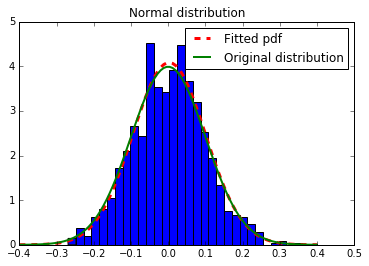

In [2]:
# Let's generate some random variables from a Gaussian distribution. Use numpy's random number generator. 
# We can specify the underlying distribution and its parameters. 
mu, sigma = 0, 0.1
data = np.random.normal(mu, sigma, size=1000)
x = np.linspace(-0.4, 0.4, 100)

# Now use matplotlib to plot the histogram
n, bins, patches = plt.hist(data, bins=30, normed=1)
plt.title('Normal distribution')

# Let's do a maximum likelihood fit on this data to estimate the parameters of the underlying distribution 
#(mu and sigma)
loc, scale = norm.fit(data)

print('estimated mean: %s' % loc)
print('estimated sigma: %s' % scale)

# Plot the original distribution and the fitted pdf
pdf = norm.pdf(x, loc=mu, scale=sigma)
pdf_norm = norm.pdf(x, loc=loc, scale=scale)
plt.plot(x, pdf_norm, 'r--', label='Fitted pdf', linewidth=3)
plt.plot(x, pdf, 'g', linewidth=2, label='Original distribution')
plt.legend()



estimated mean: -0.0245146751444
estimated sigma: 0.5


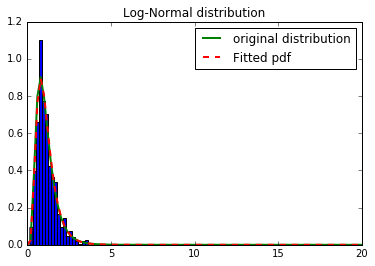

In [3]:
# Let's do the same thing with a log-Normal distribtion
mu, sigma = 0,  0.5
data = np.random.lognormal(mu, sigma, size=1000)
x = np.linspace(0, 20, 100)

n, bins, patches = plt.hist(data, bins=30, normed=1)
plt.title('Log-Normal distribution')

sigma_f, loc, scale = lognorm.fit(data)

print('estimated mean: %s' % loc)
print('estimated sigma: %s' % sigma)

pdf = lognorm.pdf(x, sigma, loc=mu)
plt.plot(x, pdf, 'g', label='original distribution', linewidth=2)
pdf_lognorm = lognorm.pdf(x, sigma_f, loc=loc, scale=scale)
plt.plot(x, pdf_lognorm, 'r--', label='Fitted pdf', linewidth=2)
plt.legend()

##### Try some other distributions.
You can find all available distributions on [scipy's docs](https://docs.scipy.org/doc/scipy/reference/stats.html).  
